# Mechanistic models of KRP4 dependent cell-size control (D'Ario et al., 2021)

## KRP4 dynamics in G2 phase of the cell cycle (an ODE model)

The article describes an ODE model that is used to capture the dynamics of the KRP4 protein during the G2 phase of the cell cycle. The model equations are as follows. 

\begin{align}
\frac{dN_{kc}}{dt}&= \beta\frac{N_kN_c}{V} - \gamma N_{kc} \\
\frac{dN_{c}}{dt}&= -\beta\frac{N_kN_c}{V} + \gamma N_{kc} \\
\frac{dN_{k}}{dt}&= -\beta\frac{N_kN_c}{V} + \gamma N_{kc} + \phi V - \mu N_k
\end{align}

Here $N_{kc}$ is the number of molecules of chromatin bound KRP4, $N_{c}$ is the number of free chromatin sites for KRP4 binding, and $N_{kc}$ is the number of molecules of free KRP4

**Exercise 1**: On the sheet provided, for each of the arrows in the model schematic, write down the process they represent

**Exercise 2**: On the sheet provided, can you map each process represented in the schematic to the corresponding term in the equations that describes the contribution from this process?

**Exercise 3**: On the sheet provided, for each of the processes described by the model, write down the parameter ($\beta$, $\gamma$, $\phi$, or $\mu$) that corresponds to this process

**Exercise 4**: On the sheet provided, write down what you think are the main assumptions made in constructing this model

**Assumption:** In this model, the nucleus volume V is assumed to increase over time during the G2 phase, at a rate that is independent of KRP4 levels.The volume $V$ at time $t$ is described by the following equation:

\begin{equation}
V = V_2g_2^t 
\end{equation}

where $g_2$ is the relative growth rate and $V_2$ is the initial nucleus volume at the start of G2 phase. Although V is changing with time, here we don't have an equation describing the time derivative of V. Instead we have something that's even simpler to use: an equation where we can just plug in the time to compute the corresponding volume. Thus, the volume V can be treated as a parameter in the ODE model -  a parameter that is itself changing with time.

Let's use this equation to plot the change in volume during G2 phase over time:

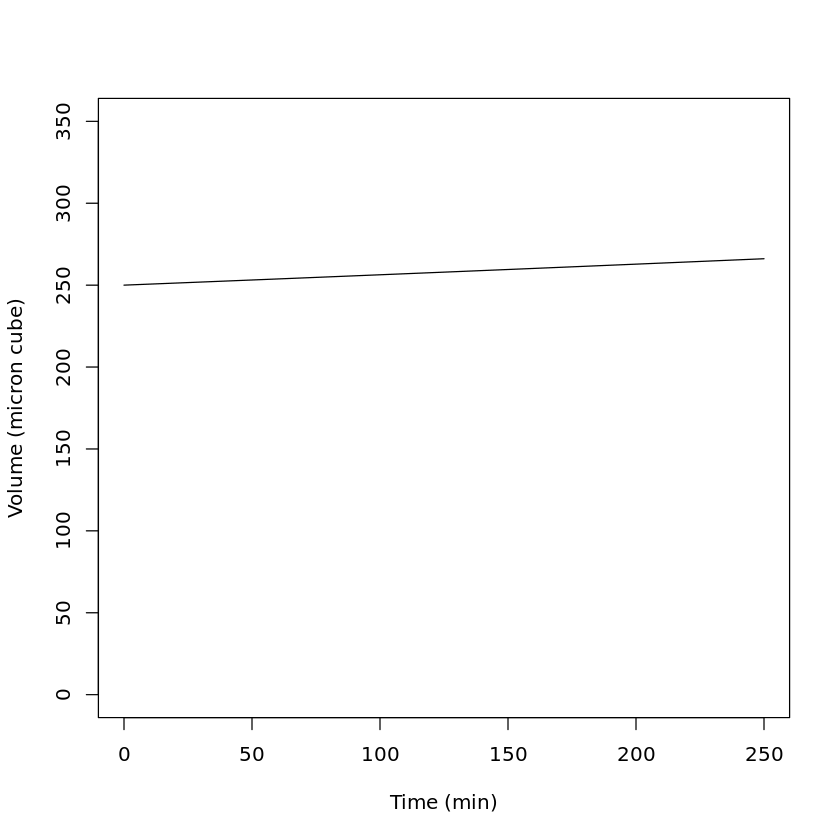

In [3]:
t=seq(0,250,1)
g2 = 1.00025
V = (g2^t)*250


plot(t,V, type="l", xlim=c(0,250), ylim=c(0,350), xlab="Time (min)", ylab="Volume (micron cube)")

We can see that the volume increase is really quite slow. Now let's try solving the ODE model equations using R. 

We begin by loading the deSolve library:

In [4]:
install.packages("deSolve") #If the package needs to be installed. If it's already installed you will get a warning - ignore it.
library("deSolve") #This is the library we will use to solve the equations


Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)



Next we specify the model equations inside an R function:

In [8]:
KRP_func<-function(t,state,parameters){
  with(as.list(c(state, parameters)),{
  if (t<=120){
    gamma=gamma_upto_120min
  } else {
    gamma=gamma_after_120min
  }
  V = (g2^t)*V2  
  
  dNkcdt = beta*Nk*Nc/V - gamma*Nkc
  dNcdt = gamma*Nkc - beta*Nk*Nc/V
  dNkdt = gamma*Nkc - beta*Nk*Nc/V + phi*V - mu*Nk
  
  list(c(dNkcdt,dNcdt,dNkdt))
  })
}

Note how we have put the equation for computing volume inside our function.

Then we specify the list of initial conditions and the list of parameter values:

In [9]:
# List of Initial conditions
state <-c(Nkc = 100,
          Nc = 100,
          Nk = 100
)

# List of Parameter values

parameters <- c(
  beta =1.5,   # this is parameter beta
  gamma_upto_120min = 1,   # this is parameter gamma upto 120min
  gamma_after_120min = 1, # this is parameter gamma after 120min
  phi = 0.4,      # this is parameter phi
  mu = 0.9,  # this is parameter mu
  g2 = 1.00025, # this is the relative growth rate in G2 phase from article
  V2 = 250 # Starting volume for G2 phase from article
)

And specify timepoints at which we want the solution evaluated:

In [10]:
times=seq(0,250,1) #Creates a vector of timepoints (minutes) at which the solution will be evaluated

Finally, we pass the function containing our model equations, along with the lists of initial conditions and parameter values to the `ode` function from the `deSolve` library:

In [11]:
sol=ode(state,times,KRP_func,parameters)

Running the above cell generates the numerical solution we want. The solution generated by the `ode` function is essentially a four column table, with our specified times as the first column, and the values of the three variables $N_{kc}$, $N_c$ and $N_k$ as the next three columns. This table is stored under the name `sol`. We can now extract these values from the table to plot the solution, and see how KRP4 levels are predicted to change over time:

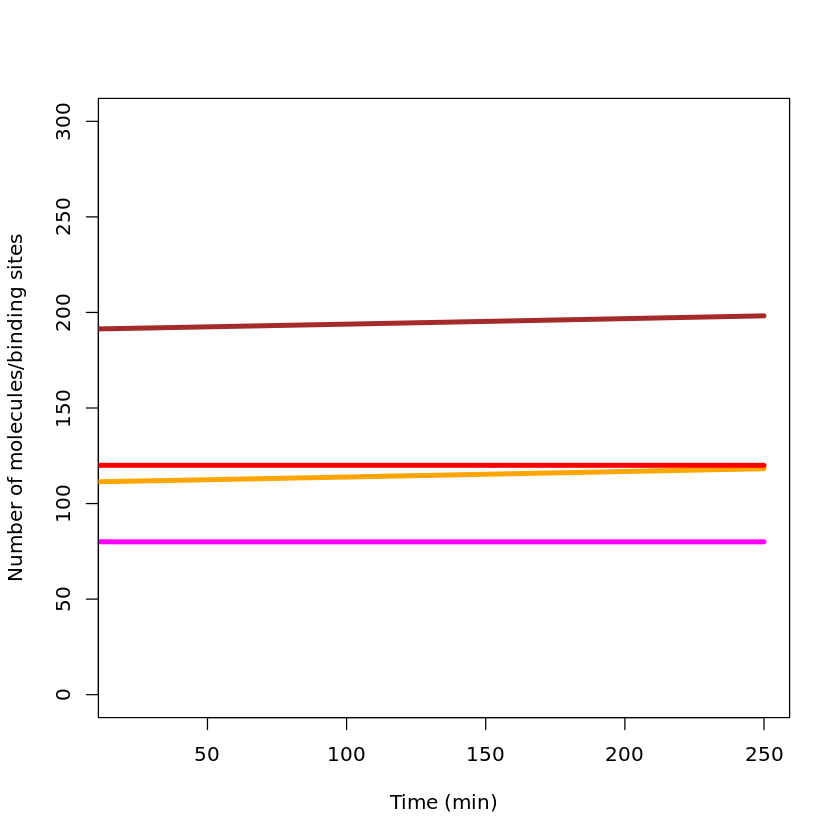

In [12]:
Nkc <- sol[,2]
Nc <- sol[,3]
Nk <- sol[,4]
Total_KRP <- Nk + Nkc

plot(times,Nkc, type="l", lwd=4,col="magenta", xlim=c(20,250), ylim=c(0,300), xlab="Time (min)", ylab="Number of molecules/binding sites")
lines(times,Nk, col="orange",lwd=4)
lines(times,Nc, col="red",lwd=4)
lines(times,Total_KRP, col="brown",lwd=4)

**Exercise 5**: By changing the parameter values for $\beta$, $\gamma$, $\phi$, and $\mu$ set above, try to recreate the solutions shown in the article (Figure 4(C)). The parameter values used to solve these equations are given in the article - can you find them?

**Bonus Exercise**: The model prediction highlighted in the article is that a decreased dissociation of KRP4 from chromatin (i.e. a decrease in the parameter $\gamma$) would cause an increase in total KRP4 levels in G2 phase. But this is not the only change that can produce an increase in total KRP4 levels in G2 phase. What if the KRP4 degradation rate is reduced instead (i.e. a decrease in the parameter $\mu$) while the dissociation is unaffected? 

Let's change the model to explore this possibility:

In [13]:
KRP_func<-function(t,state,parameters){
  with(as.list(c(state, parameters)),{
  # if (t<=120){
  #   gamma=gamma_upto_120min
  # } else {
  #   gamma=gamma_after_120min
  # }
    
    if (t<=120){
      mu=mu_upto_120min
    } else {
      mu=mu_after_120min
    }
  V = (g2^t)*V2  
  
  dNkcdt = beta*Nk*Nc/V - gamma*Nkc
  dNcdt = gamma*Nkc - beta*Nk*Nc/V
  dNkdt = gamma*Nkc - beta*Nk*Nc/V + phi*V - mu*Nk
  
  list(c(dNkcdt,dNcdt,dNkdt))
  })
}

parameters <- c(
  beta =1,   # this is parameter beta
  mu_upto_120min = 0.5,   # this is parameter gamma upto 120min
  mu_after_120min = 0.5, # this is parameter gamma after 120min
  phi = 0.1,      # this is parameter phi
  gamma = 1,  # this is parameter mu
  g2 = 1.00025, # this is the relative growth rate in G2 phase
  V2 = 250 # Starting volume
)

We can now solve the new model and plot the solutions.

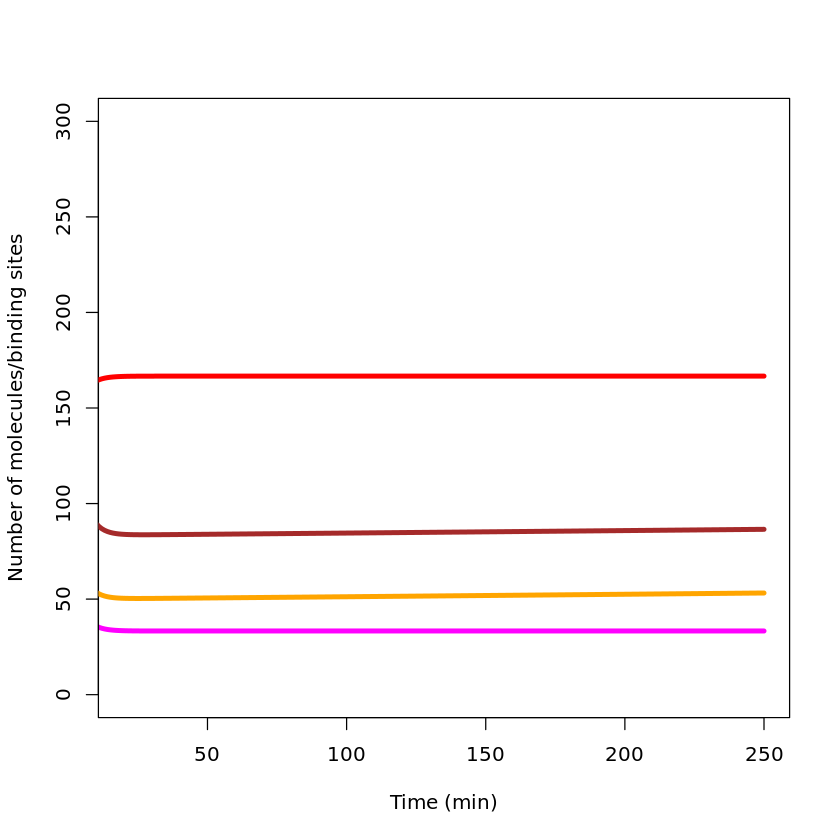

In [14]:
sol=ode(state,times,KRP_func,parameters)
Nkc <- sol[,2]
Nc <- sol[,3]
Nk <- sol[,4]
Total_KRP <- Nk + Nkc

plot(sol[,1],Nkc, type="l", lwd=4,col="magenta", xlim=c(20,250), ylim=c(0,300), xlab="Time (min)", ylab="Number of molecules/binding sites")
lines(sol[,1],Nk, col="orange",lwd=4)
lines(sol[,1],Nc, col="red",lwd=4)
lines(sol[,1],Total_KRP, col="brown",lwd=4)

Can you spot any obvious differences to what we saw earlier? Which solution curve do you think shows the clearest difference?

**Answer:**